# National

In [512]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.stats import  fisk
from sklearn.metrics import r2_score

# Four Wheeler

In [614]:
income = pd.read_csv("output_1.csv", low_memory=False)
four_wheeler = pd.read_csv("output_3.csv", low_memory=False)

In [615]:
merged_df_1 = pd.merge(four_wheeler, income, on='id', how='inner')
merged_df_1['vehicles_owned'] = merged_df_1['total_car_count'] / merged_df_1['household_size']
merged_df_1['vehicles_owned'] = merged_df_1['total_car_count']
merged_df_1 = merged_df[['id', 'vehicles_owned','per_capita_income']]
merged_df_1.to_csv('2014_car.csv', index=True)

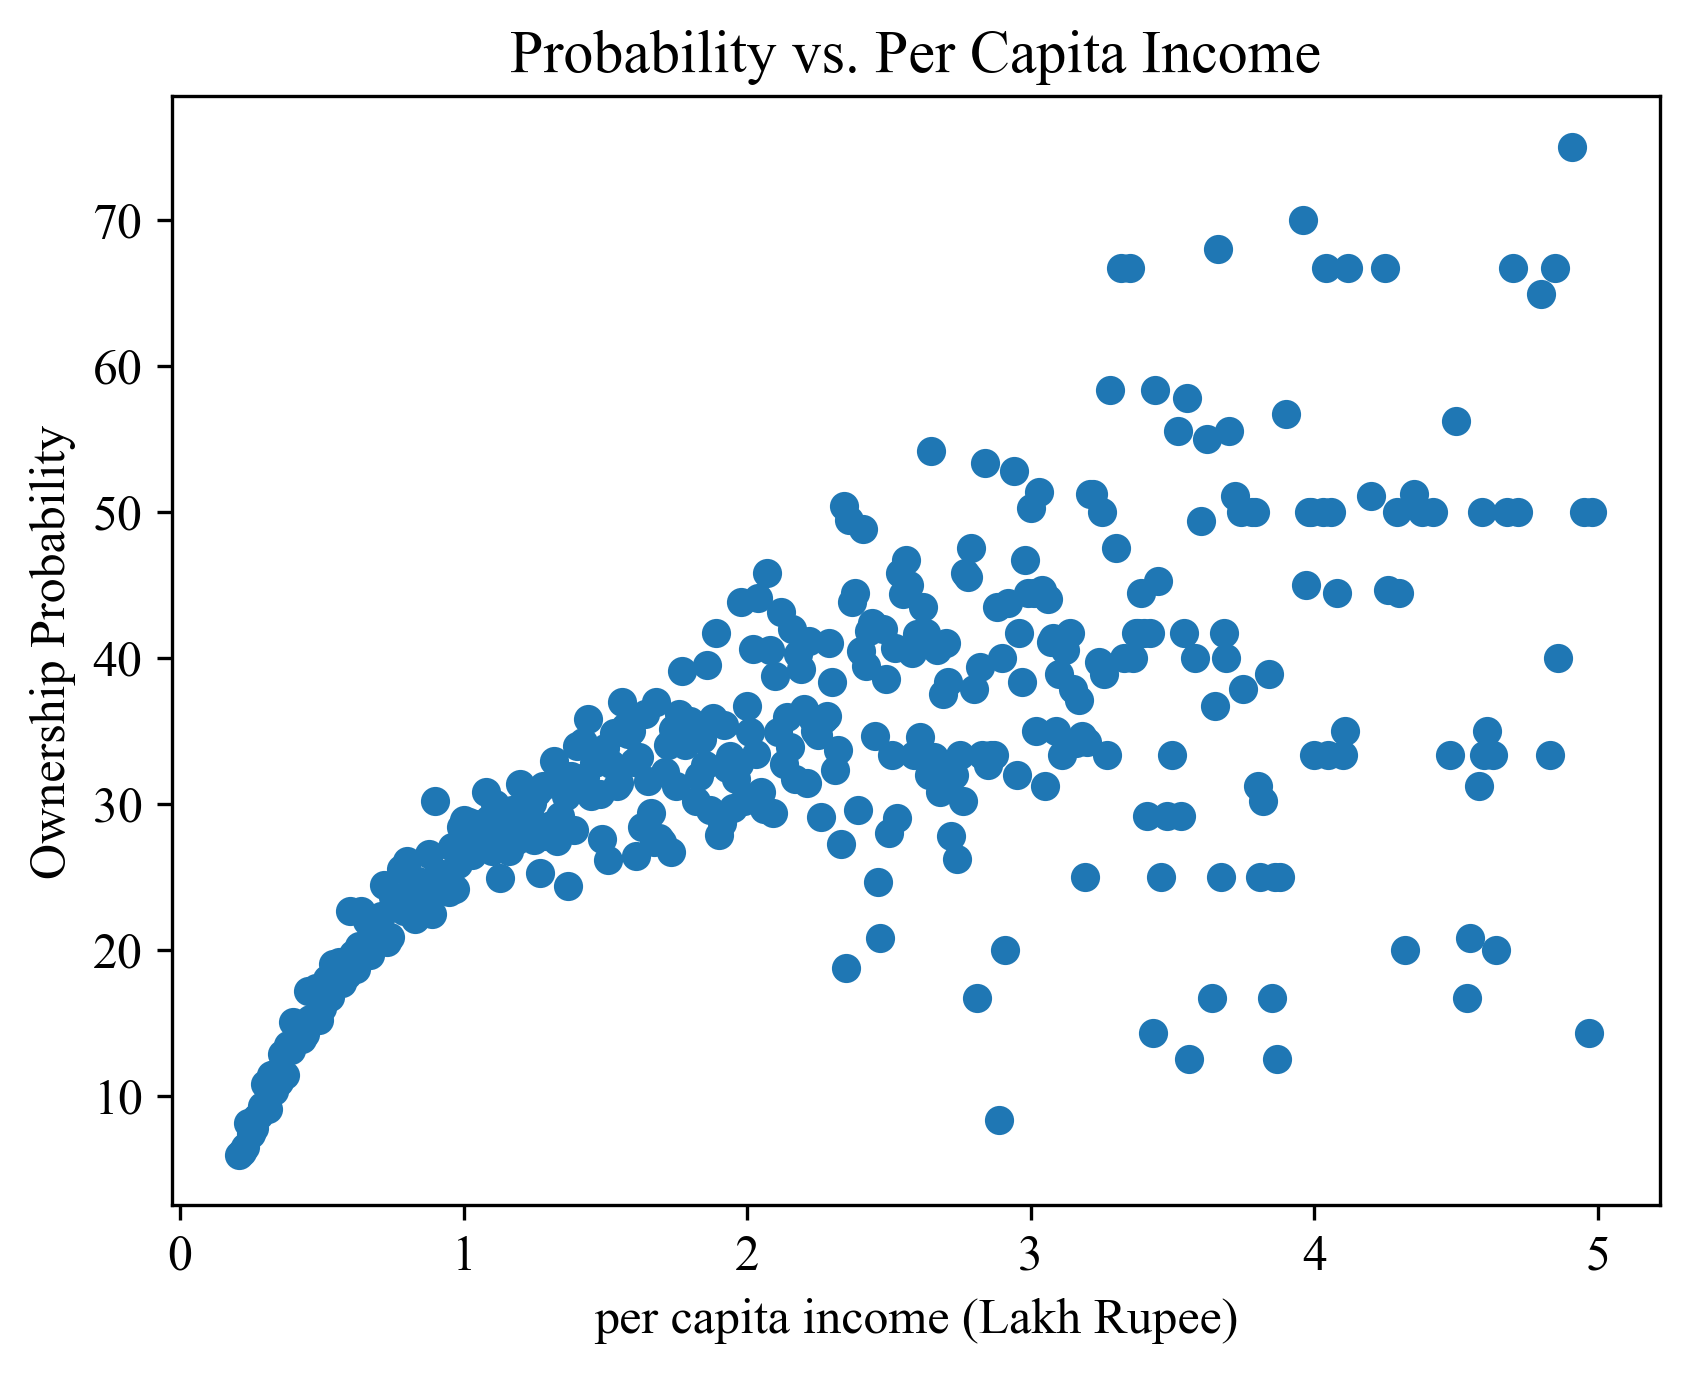

,per_capita_income,income_count,total_four_wheeler_count,ownership_probability
0,0.24,4542,369.921415,8.144461
5,0.22,3424,211.706772,6.183025
6,0.36,3368,434.229228,12.892792
7,0.30,3354,362.813997,10.817352
8,0.21,3127,186.429698,5.961935
...,...,...,...,...
481,4.98,1,0.500000,50.000000
483,4.29,1,0.500000,50.000000
485,4.03,1,0.500000,50.000000
486,4.83,1,0.333333,33.333333


In [616]:
# Data Preprocessing
df_final = pd.read_csv('2014_car.csv')
df_final['per_capita_income'] = pd.to_numeric(df_final['per_capita_income'], errors='coerce')

# Bucketing based on income ranges
df_final['per_capita_income'] = df_final['per_capita_income'].apply(lambda x: round(x, -3))

df_income_counts = df_final['per_capita_income'].value_counts().reset_index()
df_income_counts.columns = ['per_capita_income', 'income_count']

df_four_wheeler_count = df_final.groupby('per_capita_income')['vehicles_owned'].sum().reset_index()
df_four_wheeler_count.columns = ['per_capita_income', 'total_four_wheeler_count']

df_merged = pd.merge(df_income_counts, df_four_wheeler_count, on='per_capita_income')
df_merged = df_merged[df_merged['income_count'] > 0]

df_merged['ownership_probability'] = df_merged['total_four_wheeler_count'] / df_merged['income_count']
df_merged['ownership_probability'] = df_merged['ownership_probability'] * 100
df_merged['per_capita_income'] = df_merged['per_capita_income'] / 100000


df_merged = df_merged[(df_merged['per_capita_income'] < 5) & (df_merged['per_capita_income'] > 0.2)]
df_merged = df_merged[(df_merged['ownership_probability'] < 100) & (df_merged['ownership_probability'] > 0)]

# Plotting
plt.plot(df_merged['per_capita_income'], df_merged['ownership_probability'], marker='o', linestyle='')

plt.xlabel('per capita income (Lakh Rupee)')
plt.ylabel('Ownership Probability')
plt.title('Probability vs. Per Capita Income')
plt.show()
df_merged

rGompertzFunction r2: 0.5120962724316184
Parameters: [-1.641097   -1.14184761  0.42286456]


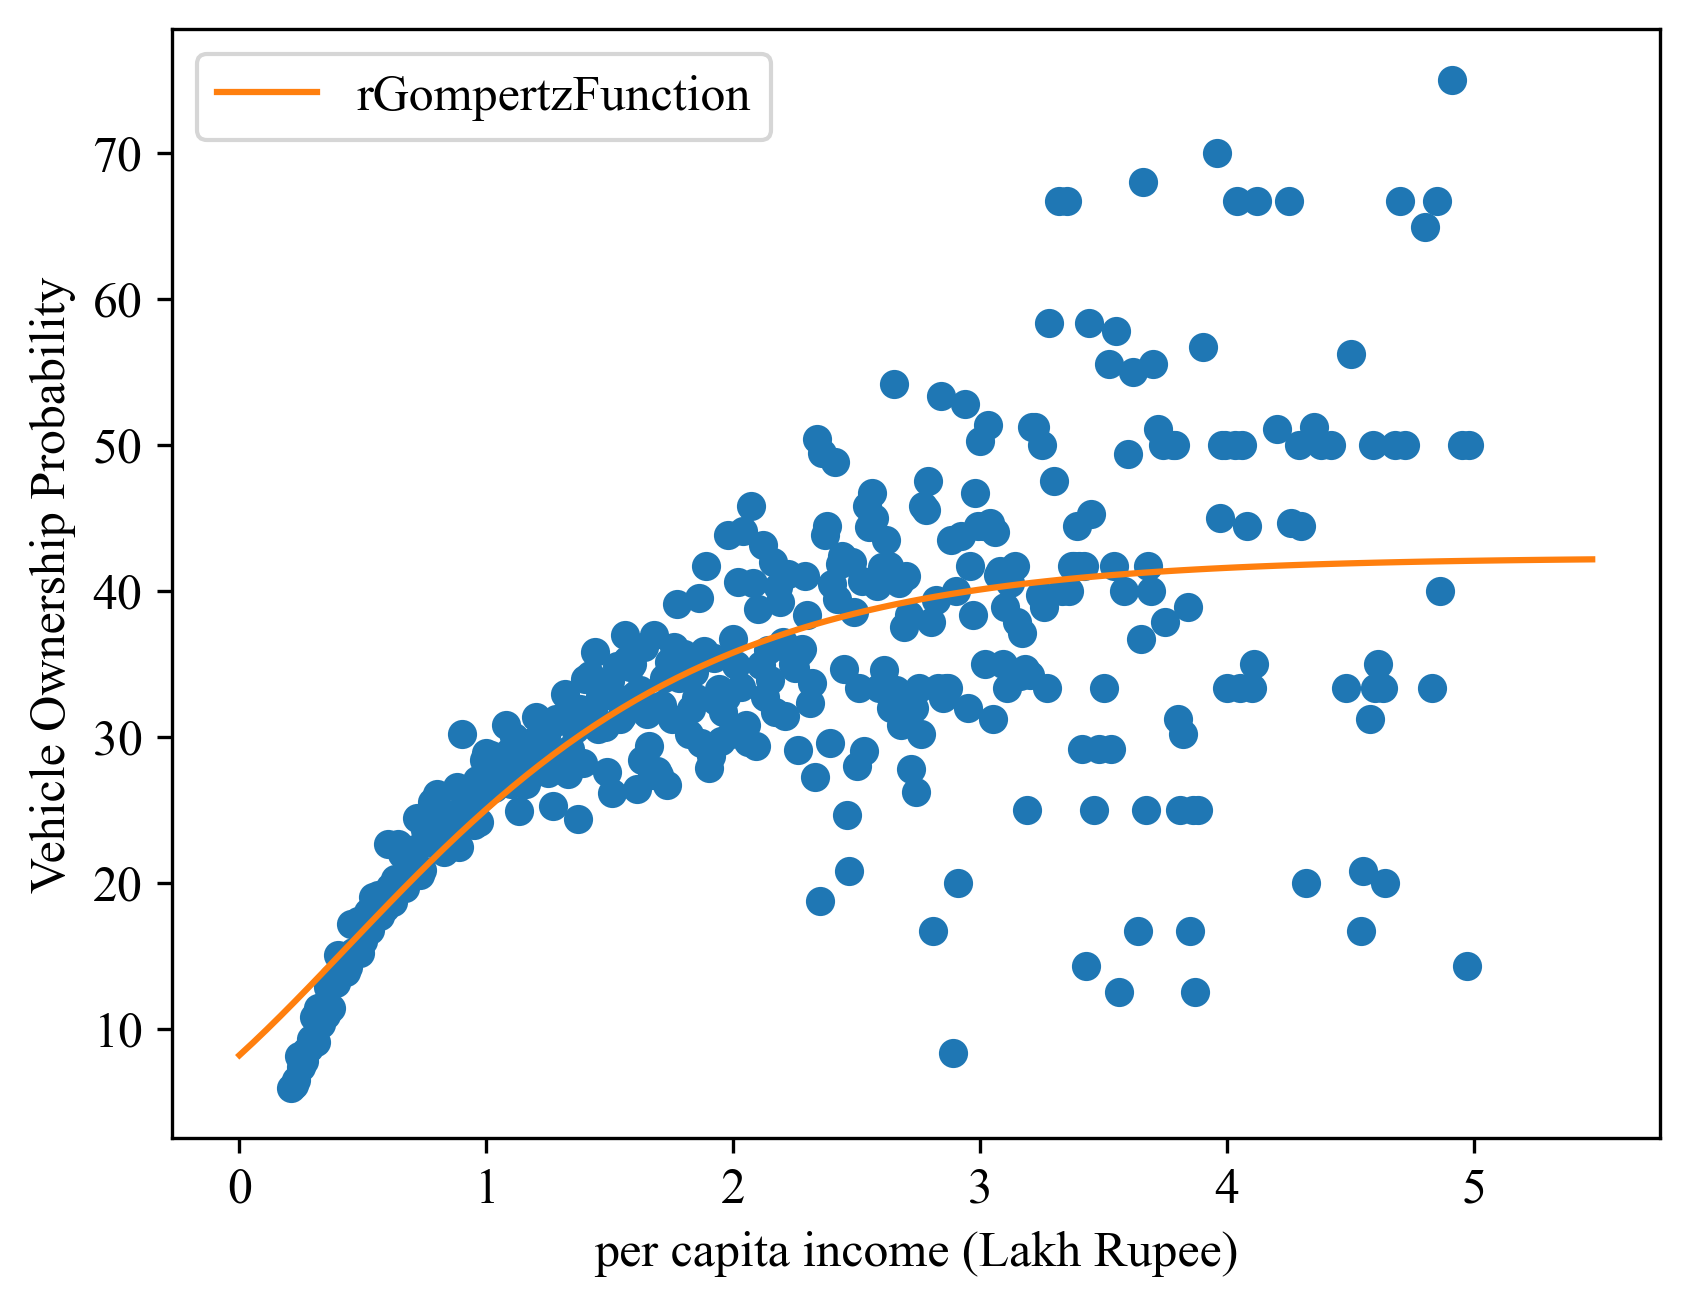

In [617]:
#Curve Fiting
def rGompertzFunction(x, a, b, r):
    return r * (np.exp(a * (np.exp(b * x))))

x_data = df_merged['per_capita_income']
y_data = df_merged['ownership_probability'] / 100

plt.plot(x_data, y_data * 100, 'o')
pars, pcov = curve_fit(rGompertzFunction, x_data, y_data, maxfev=9000, p0=[-3, 0, max(y_data)])
plot_x = np.linspace(0, max(x_data) * 1.1, 100)
plot_y = rGompertzFunction(plot_x, *pars) * 100

plt.plot(plot_x, plot_y, label='rGompertzFunction')

r2 = r2_score(y_data, rGompertzFunction(x_data, *pars))
print('rGompertzFunction r2:', r2)

print('Parameters:', pars)

# Plotting
plt.xlabel('per capita income (Lakh Rupee)')
plt.ylabel('Vehicle Ownership Probability')
plt.legend()
plt.show()

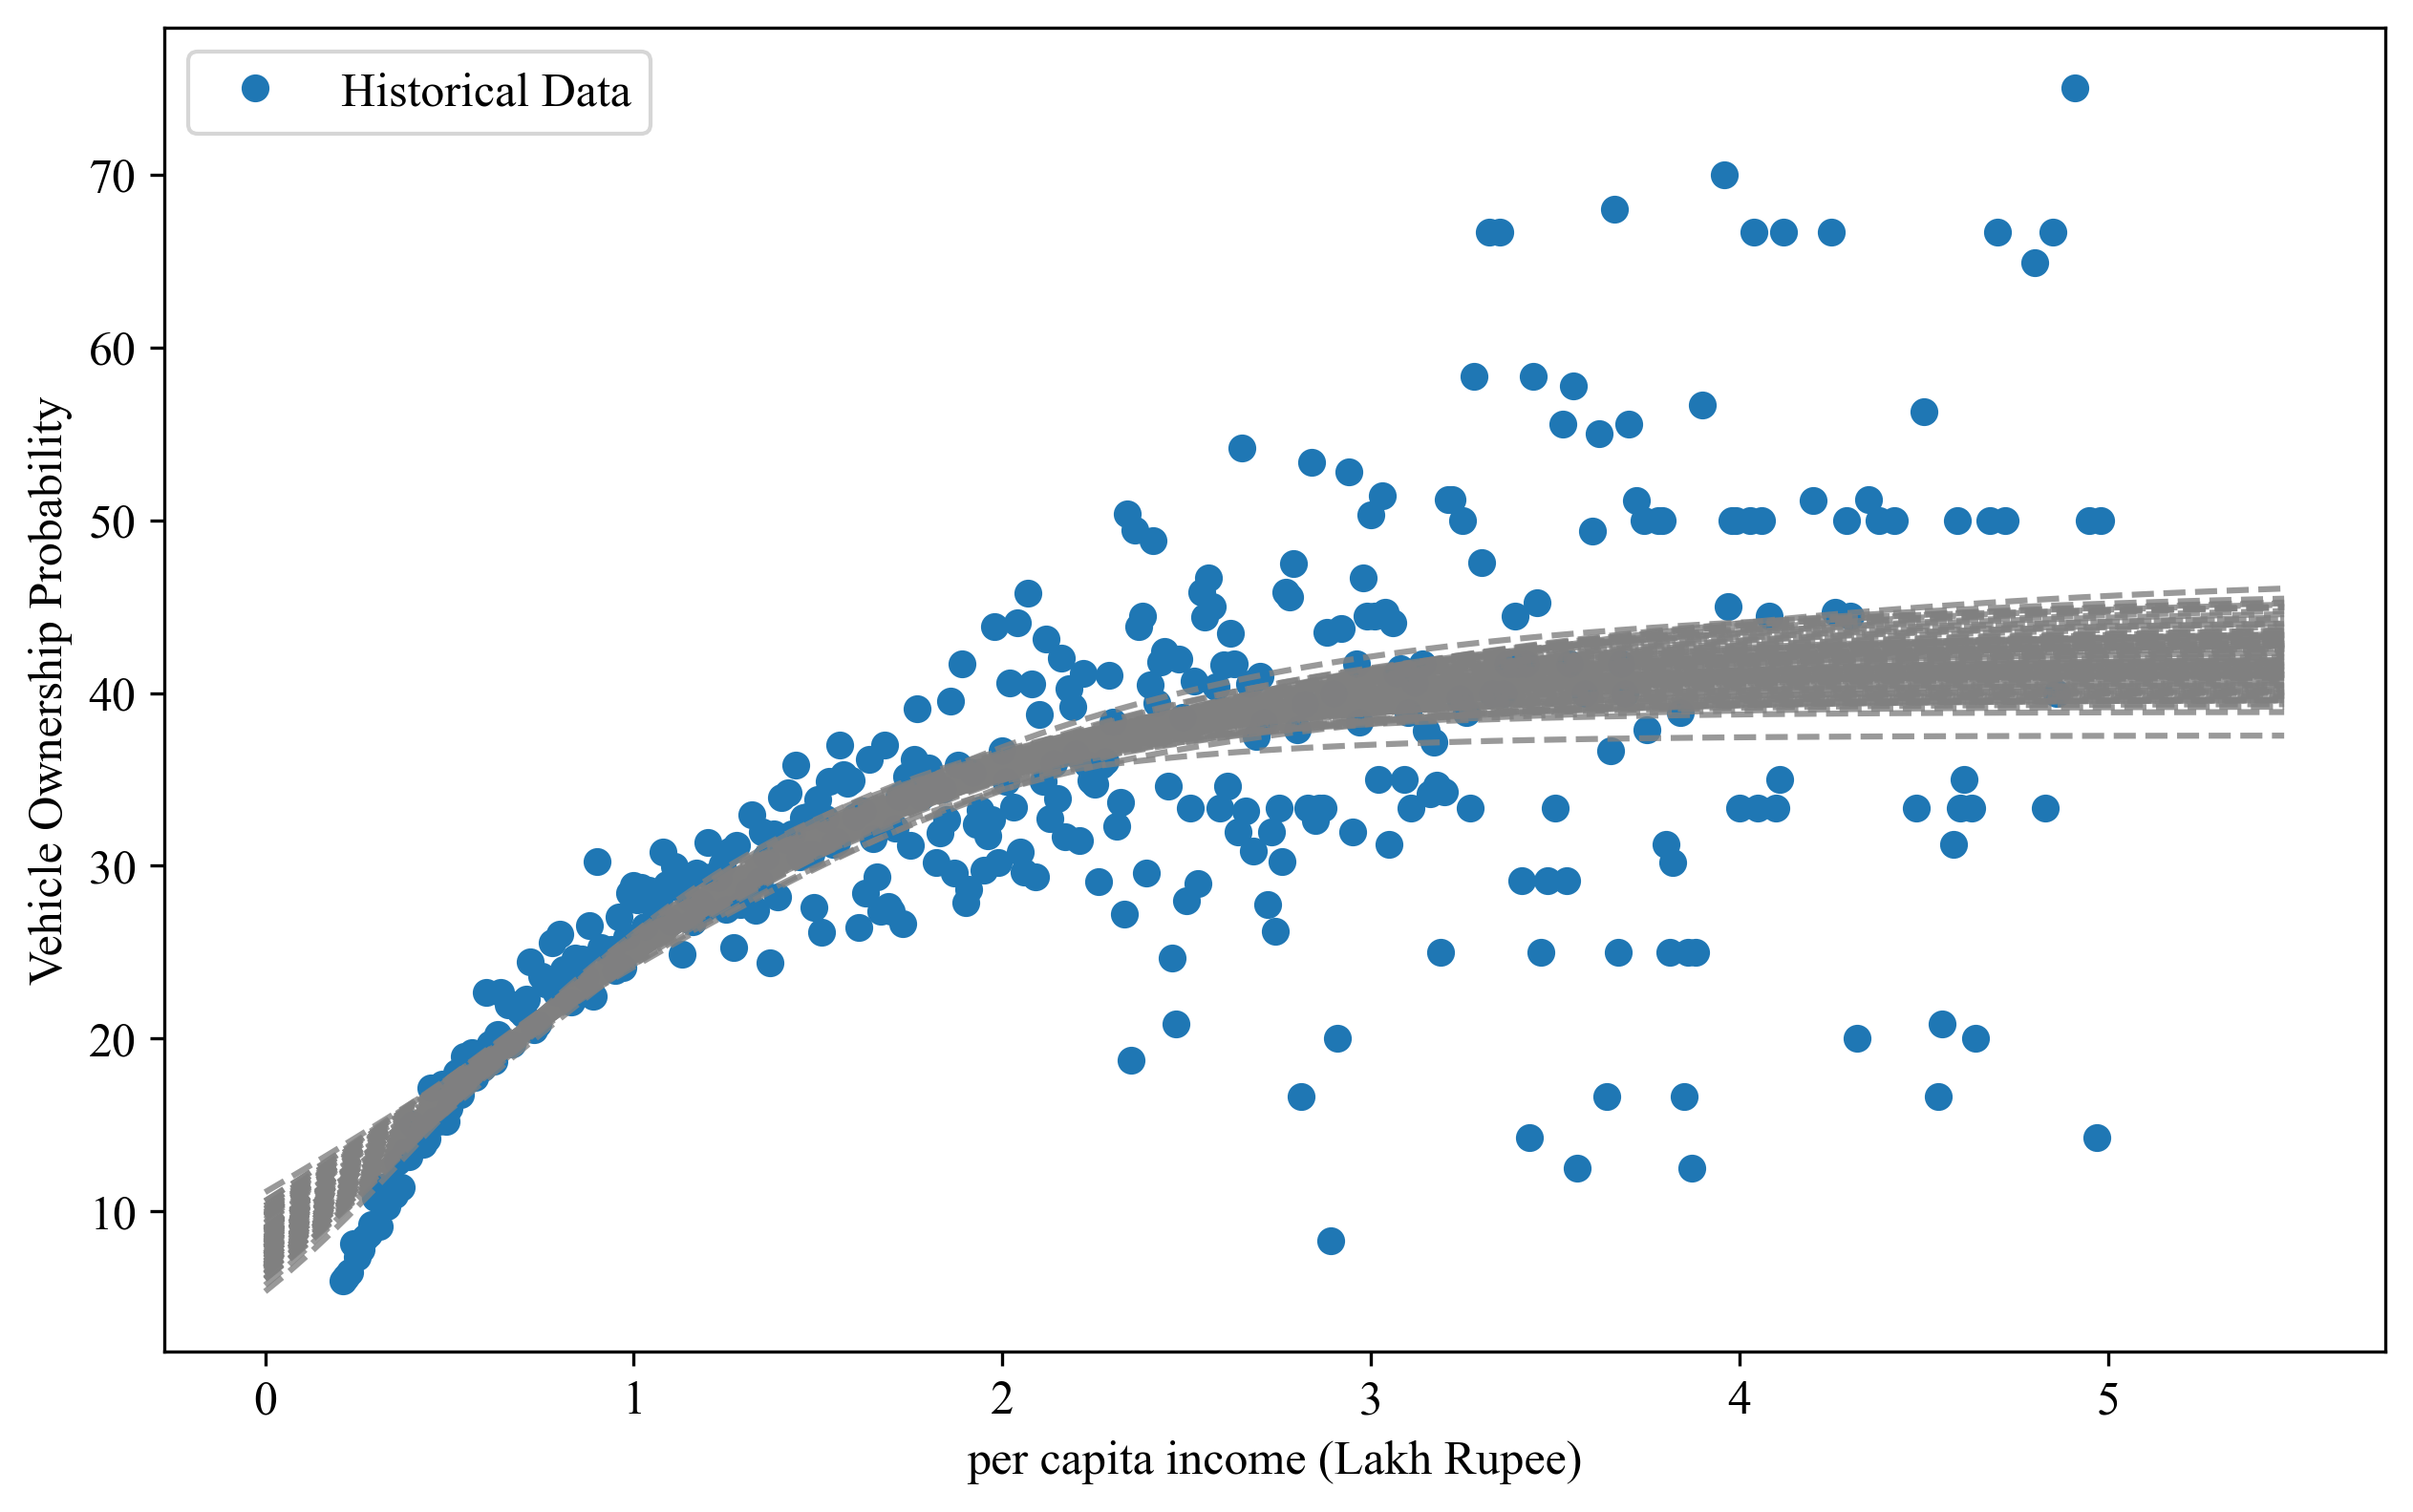

In [618]:
# Reset the index of the data
x = x_data.reset_index(drop=True)
y = y_data.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(x, y * 100, 'o', label='Historical Data')

# Bootstrap Resampling
n_iterations = 100  # Number of bootstrap samples
bootstrap_params = []  # Store the curve parameters for each bootstrap sample

for _ in range(n_iterations):
    # Resampling the data points
    resampled_indices = np.random.choice(range(len(x)), size=len(x), replace=True)
    resampled_x = x[resampled_indices]
    resampled_y = y[resampled_indices]

    # Curve Fitting
    bootstrap_pars, _ = curve_fit(rGompertzFunction, resampled_x, resampled_y, maxfev=9000, p0=[-3, 0, max(y_data)])
    bootstrap_params.append(bootstrap_pars)

bootstrap_params = np.array(bootstrap_params)

# Plotting bootstrapped curves
for bootstrap_pars in bootstrap_params:
    plt.plot(plot_x, rGompertzFunction(plot_x, *bootstrap_pars) * 100, color='gray', linestyle='--', alpha=0.8)

# Calculating percentiles
params_percentiles = np.percentile(bootstrap_params, [2.5, 50, 97.5], axis=0)

df_params = pd.DataFrame(params_percentiles.T, columns=['alpha', 'beta', 'gamma'], index=['2.5', '50', '97.5'])

# Saving DataFrame to a CSV file
df_par.to_csv('bootstrap_params.csv', index=True)

plt.xlabel('per capita income (Lakh Rupee)')
plt.ylabel('Vehicle Ownership Probability')
plt.legend()
plt.show()
